# State Farm Distracted Driver Competition

- Training: List of images of distracted drivers along with what distracts them.
- Test: Given a list of images identify what distracts the drivers.

## Imports and Data Loading

In [83]:
from fastai.vision import *
from fastai.callbacks.hooks import *
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [2]:
np.random.seed(62)

In [3]:
imgs = Path('/home/jupyter/state-farm-distracted-driver-detection/imgs')

In [4]:
train_path = imgs/'train'
test_path = imgs/'test'

In [5]:
dbunch = ImageDataBunch.from_folder(
    train_path, # folder that contains the data
    train=".", # relative location of the folder of the training set
    valid_pct=0.2, # Percentage of validation set
    ds_tfms=get_transforms(), # transformations - use default
    size=224, # size of images
    num_workers=8 # number of cpu workers
).normalize(imagenet_stats) # normalize via imagenet stats

In [6]:
dbunch.classes

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

The 10 classes correspond to:

- *c0*: safe driving
- *c1*: texting - right
- *c2*: talking on the phone - right
- *c3*: texting - left
- *c4*: talking on the phone - left
- *c5*: operating the radio
- *c6*: drinking
- *c7*: reaching behind
- *c8*: hair and makeup
- *c9*: talking to passenger


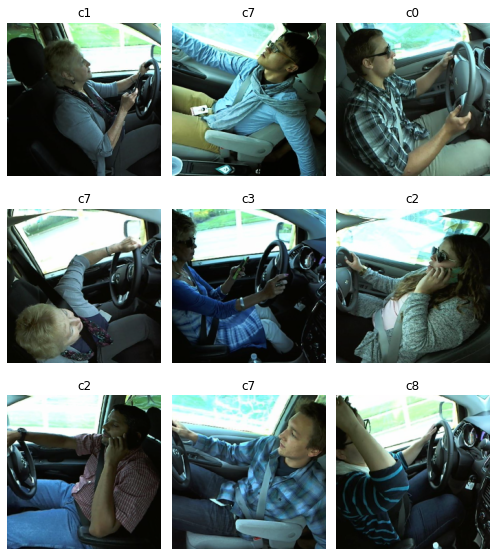

In [7]:
dbunch.show_batch(rows=3, figsize=(7,8))

## Modeling & Training

Use a Convolutional Neural Network and transfer learning from the pretrained model resnet50 which was trained on imagenet.

In [6]:
learn = cnn_learner(dbunch, models.resnet50, metrics=[error_rate])

Plot learning rates along with the error they produce.

epoch,train_loss,valid_loss,error_rate,log_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


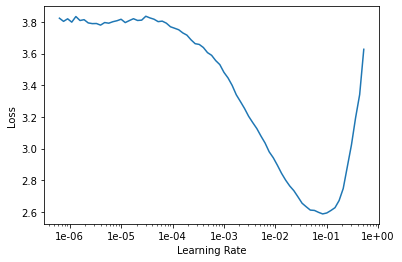

In [12]:
learn.lr_find()
learn.recorder.plot()

Training time!

- Train only the last layer of the CNN (because the rest of the model is already pretrained).

- Train for 4 epochs (= passes of the training set) using a learning rate of `2e-2`.

- Chose this learning rate by finding a steep slope near the global minimum.

In [17]:
learn.fit_one_cycle(4, 2e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.681105,0.732354,0.177520,02:33
1,0.321627,0.751220,0.206512,02:29
2,0.167388,0.076064,0.022971,02:31
3,0.083096,0.063104,0.017395,02:29


1.7% error with just ~10 minutes of training!!

Save our model parameters to avoid retraining in the future (a costly operation!).

In [20]:
learn.save('resnet50-stage-1')

In [21]:
learn.load('resnet50-stage-1');

Unfreeze the model to train all layers of the CNN.

This allows earlier parameters to become more specific to our training set.

In [22]:
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


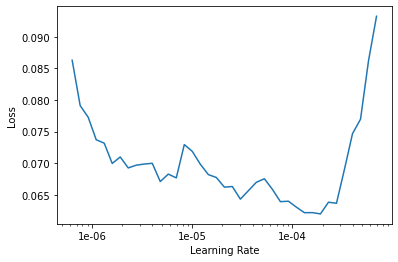

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,2e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.068617,0.053479,0.012489,03:20
1,0.052006,0.048477,0.012043,03:19


We were able to get the loss down to 1.2%!

In [25]:
learn.save('resnet50-stage-2')

In [7]:
learn.load('resnet50-stage-2');

## Interpretation of failed cases

Let's interpret our results learning model to find out where the 1.2% error comes from.

In [29]:
interp = ClassificationInterpretation.from_learner(learn)

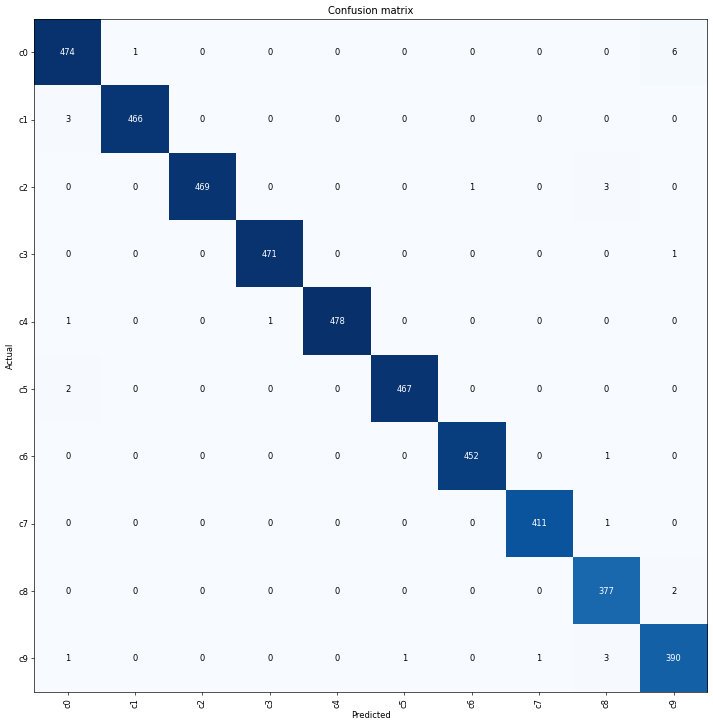

In [30]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

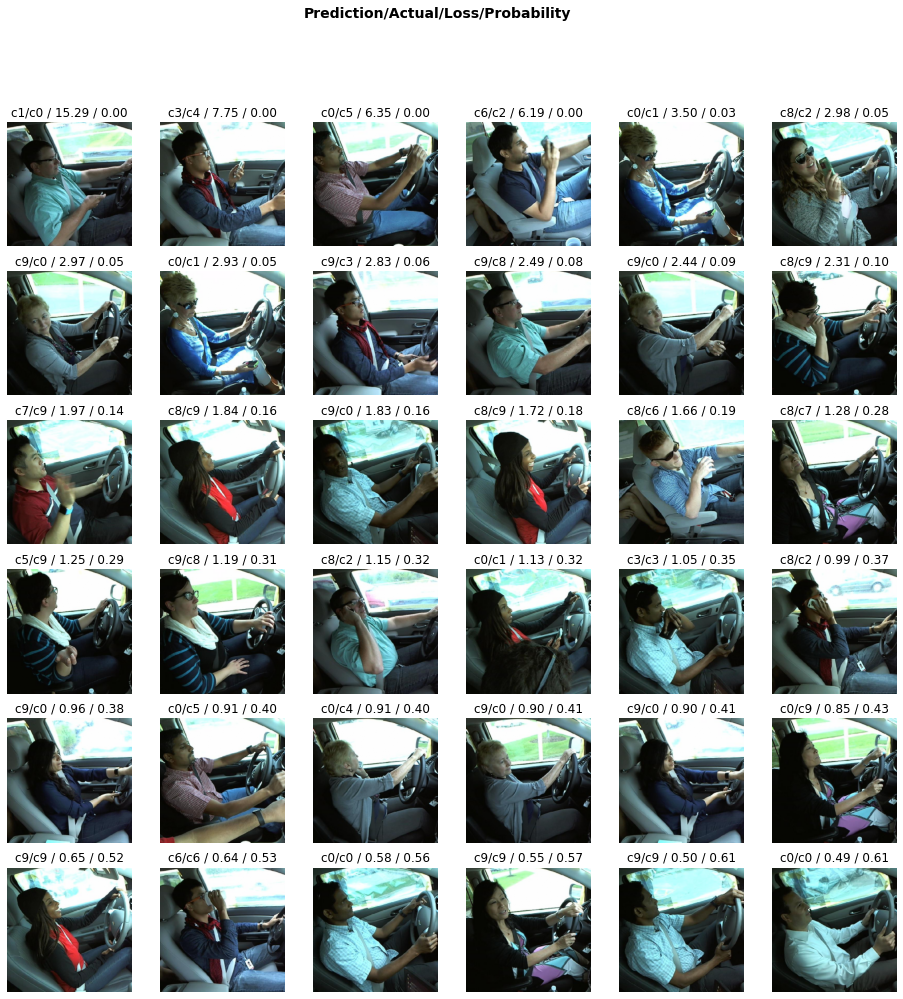

In [20]:
interp.plot_top_losses(36, figsize=(16,16))

### Convolution Kernel Heatmap

We're gonna check the images of the false predictions generated by our model, and then
we're gonna plot a heatmap to see where the convolution kernels focus to produce our prediction.

First we're gonna get the predictions and define a function that returns the errors for a class.

In [32]:
# get predictions on the validation set
preds = learn.get_preds(ds_type=DatasetType.Valid)[0].argmax(-1)

In [33]:
cat_valid = torch.tensor([c.data for c in dbunch.valid_ds.y])

In [34]:
imgs_valid = dbunch.valid_ds.x

In [42]:
def get_errors_by_class():
    errors = {}
    for i in range(10):
        errors[i] = []
        
    for idx, (pred, valid) in enumerate(zip(preds, cat_valid)):
        if pred != valid:
            errors[int(valid)].append((int(pred), imgs_valid[idx]))
    return errors

In [43]:
errs = get_errors_by_class()

`errs` is a map mapping categories to the outputs of the neural network that were a wrong prediction for that class. We will use it to view the reasons behind the false negatives by plotting a heatmap over the image that shows what part of the image produced the largest activations, meaning which part of the image led to the wrong prediction.

In [157]:
errs

{0: [(9, Image (3, 480, 640)),
  (9, Image (3, 480, 640)),
  (9, Image (3, 480, 640)),
  (9, Image (3, 480, 640)),
  (1, Image (3, 480, 640)),
  (9, Image (3, 480, 640)),
  (9, Image (3, 480, 640))],
 1: [(0, Image (3, 480, 640)),
  (0, Image (3, 480, 640)),
  (0, Image (3, 480, 640))],
 2: [(8, Image (3, 480, 640)),
  (6, Image (3, 480, 640)),
  (8, Image (3, 480, 640)),
  (8, Image (3, 480, 640))],
 3: [(9, Image (3, 480, 640))],
 4: [(0, Image (3, 480, 640)), (3, Image (3, 480, 640))],
 5: [(0, Image (3, 480, 640)), (0, Image (3, 480, 640))],
 6: [(8, Image (3, 480, 640))],
 7: [(8, Image (3, 480, 640))],
 8: [(9, Image (3, 480, 640)), (9, Image (3, 480, 640))],
 9: [(8, Image (3, 480, 640)),
  (7, Image (3, 480, 640)),
  (8, Image (3, 480, 640)),
  (5, Image (3, 480, 640)),
  (0, Image (3, 480, 640)),
  (8, Image (3, 480, 640))]}

First, define an array mapping class indexes to their description.

In [138]:
desc_arr = ["safe driving", "texting - right",
            "talking on the phone - right",
            "texting - left",
            "talking on the phone - left",
            "operating the radio", "drinking",
            "reaching behind", "hair and makeup",
            "talking to passenger"]

The juicy part of the implementation:

We define a function `plot_heatmap` that takes an image, the prediction made for that image and its correct class. We plot the image and above it we plot a heatmap showing the pixels that triggered the biggest activations of the neural net.

In [170]:
# this is our model. m[0] represents the convolution part
model = learn.model.eval()
def plot_heatmap(ax, img, pred, valid):
    # Get the normalized image data from our databunch
    xb, _ = dbunch.one_item(img)
    # denormalize the data and create an image object
    xb_im = Image(dbunch.denorm(xb)[0])
    # hook to the output of the neural network
    # so we can see the activations of the last layer
    with hook_output(m[0]) as hook_a:
        model(xb)[0, valid].backward()
    # activations is a 2048 x 7 x 7 tensor
    # 2048 = #channels, 7x7 is the reduced size of the image due to kernel strides
    activations = hook_a.stored[0].cpu()
    # take the mean of the channels
    avg_acts = activations.mean(0)
    # Plot the image and the heatmap
    ax.set_title("{}".format(desc_arr[pred]))
    xb_im.show(ax)
    ax.imshow(avg_acts, alpha=0.6, extent=(0, 224, 224, 0), interpolation='bilinear', cmap='magma')

In [171]:
def plot_for_cat(cat, inv):
    _, ax = plt.subplots(len(inv), figsize=(24,24))
    print ("Predicted")
    for idx, (pred, img) in enumerate(inv):
        plot_heatmap(ax[idx], img, pred, cat)

First let's plot our biggest loser, `Talking to Passenger`.

Actual:  talking to passenger
Predicted


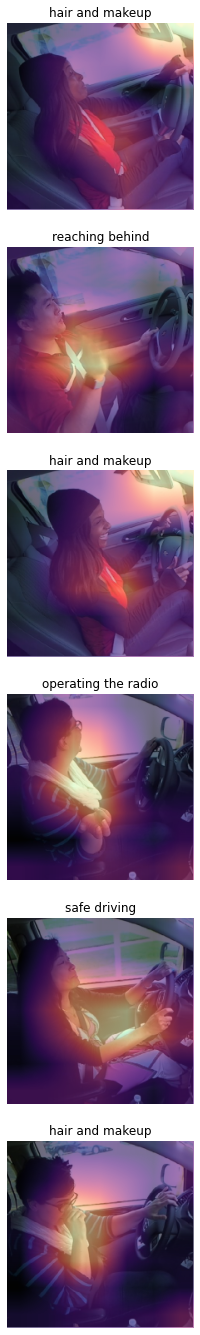

In [174]:
print ("Actual: ", desc_arr[9])
plot_for_cat(9, errs[9])

Let's plot for class c0 -> not distracted.

Actual:  safe driving
Predicted


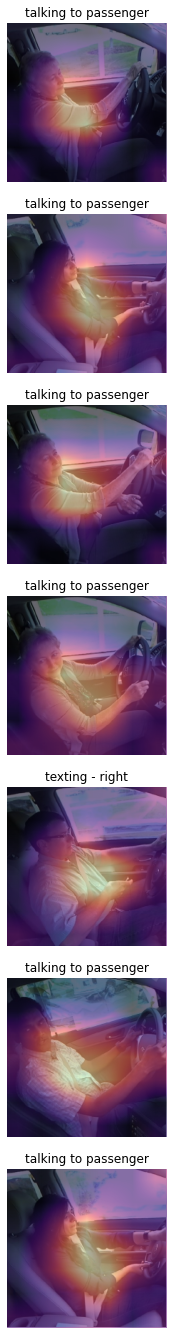

In [176]:
print ("Actual: ", desc_arr[0])
plot_for_cat(0, errs[0])

One more:

Actual:  texting - right
Predicted


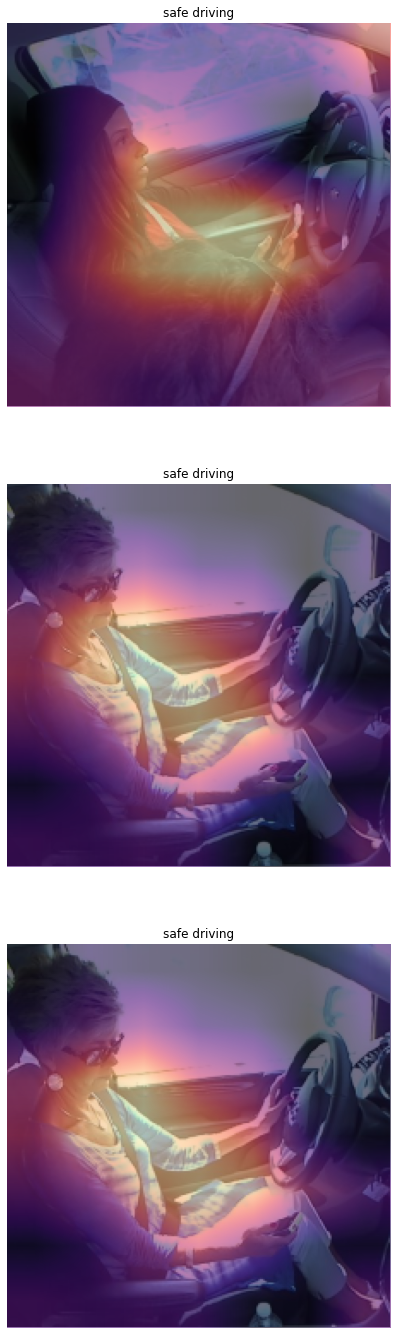

In [179]:
print ("Actual: ", desc_arr[1])
plot_for_cat(1, errs[1])

## Test Set Predictions

Get predictions to submit.

In [31]:
dbunch.add_test(ImageList.from_folder(test_path))

In [34]:
learner = cnn_learner(dbunch, models.resnet50)
learner.load('resnet50-stage-2');

In [35]:
preds, y = learn.get_preds(ds_type=DatasetType.Test)

In [36]:
submission = pd.DataFrame({'img': os.listdir(imgs/'test'),
                          'c0': preds[:,0],
                          'c1': preds[:,1],
                          'c2': preds[:,2],
                          'c3': preds[:,3],
                          'c4': preds[:,4],
                          'c5': preds[:,5],
                          'c6': preds[:,6],
                          'c7': preds[:,7],
                          'c8': preds[:,8],
                          'c9': preds[:,9]})

In [37]:
submission.to_csv('/home/jupyter/distracted-driving.csv', index=False)

Submission got a score that would've putted it in the 219 place out of 1438 contestants -> 15% of best submissions.